This was made by following along with the webinar posted here: https://www.youtube.com/watch?v=NoixdExFb7Y&t=7349s

In [ ]:
!pip install transformers

     |████████████████████████████████| 481kB 3.4MB/s 
     |████████████████████████████████| 3.1MB 14.9MB/s 
     |████████████████████████████████| 1.0MB 24.4MB/s 
     |████████████████████████████████| 870kB 42.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=177dab850fba7d16688ede90936e9886daada6c42d0ecd1edbd09d49415f5d6e
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


Basic Preprocessing Example

In [ ]:
import json
import os
import torch
import numpy as np
import pandas as pd
from transformers import BertModel, BertTokenizer

# Prepare Data

In [ ]:
from google.colab import files

uploaded = files.upload()
#print(uploaded)
filename = list(uploaded.keys())[0]

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving k_means_data.json to k_means_data.json
User uploaded file "k_means_data.json" with length 2333695 bytes


In [ ]:
#process the file
article_dict = json.loads(str(uploaded[filename], 'utf-8'), encoding='utf-8')
article_dict = dict(article_dict)
articles = []
names = []
for article in article_dict:
  if article != 'Missing Technologies':
    text = article_dict[article]['snippet']
    name = article_dict[article]['company']
    articles.append(text)
    names.append(name)
print("There are {} articles and {} names from the dataset.".format(len(articles), len(names)))

There are 2153 articles and 2153 names from the dataset.


# Initialize the BERT Model

In [ ]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
  print("Using the GPU: " + torch.cuda.get_device_name(0))
else:
  device = 'cpu'
  print("No GPU available. Using CPU instead.")

Using the GPU: Tesla T4


In [ ]:
from torch import nn

In [ ]:
class BertClassifier(nn.Module): #custom models will always inherit from the nn.Module class of torch

  def __init__(self):
    super(BertClassifier, self).__init__()
    #self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
    self.bert_layer = BertModel.from_pretrained('bert-large-uncased')
    self.dropout = nn.Dropout(0.1)
    self.classifier = nn.Linear(768, 1) #N.B. that 768 is the length of the 3rd dimension of the unsqueezed hidden representation and classification tag heads
  
  def forward(self, seq, attn_masks):
    """
		Inputs:
			seq : Tensor of shape [B, T] containing token ids of sequences
			attn_masks : Tensor of shape [B, T] containing attenntion masks to be used to avoid co...
		"""
    seq_repr, _ = self.bert_layer(seq, attention_mask=attn_masks)
    cls_repr = seq_repr[:,0] #the first token is always the classification token
    logits = self.classifier(cls_repr)
    return logits, cls_repr

In [ ]:
model = BertClassifier()
model.to(device)

BertClassifier(
  (bert_layer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, ele

In [ ]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.00002)

Training Methods

In [ ]:
#confirm that the GPU memory is available (this must be done or else I get a "RuntimeError: CUDA out of memory." message and the model doesn't train)
!pip install gputil
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 24% |


**PREDICTIONS WITH THE MODEL**

In [ ]:
#convert a new message into WordPiece tokens, and then into the input vectors
def preprocess(message, maxlen=512):
  #tokenization, special tokens, padding, attention mask, token ids
  tokens = tokenizer.tokenize(message)                            #tokenization
  tokens = ['[CLS]'] + tokens + ['[SEP]']                         #special tokens
  if len(tokens) < maxlen:                                        #padding
    tokens = tokens + ['[PAD]' for _ in range(maxlen - len(tokens))]
  else:
    tokens = tokens[:maxlen-1] + ['[SEP]']
  token_ids = tokenizer.convert_tokens_to_ids(tokens)             #token ids
  token_ids = torch.tensor(token_ids)
  attn_mask = (token_ids != 0).long()   
  return token_ids, attn_mask

In [ ]:
def predict(model, seq, attn_masks, device):
  total_loss = 0
  model.eval()
  #load the data
  seq, attn_masks = seq.unsqueeze(0).to(device), attn_masks.unsqueeze(0).to(device)
  #get logit predictions
  logits, cls_repr = model(seq, attn_masks)
  return logits, cls_repr

In [ ]:
#for each article, get the [CLS] token vector for the last transformer layer
predictions = []
for a in articles:
  seq, attn = preprocess(a)
  #print(seq.shape, attn.shape)

  prediction, cls = predict(model, seq, attn, device)
  cls = torch.Tensor.cpu(cls)
  #print(cls.shape)
  cls = cls.squeeze().tolist()
  predictions.append(cls)
print("There are {} articles and {} predictions.".format(len(articles), len(predictions)))

RuntimeError: ignored

# Clustering by the Elbow Method

We have taken a set of news articles about technology used by companies
and pass the raw text through the BERT tokenizer. Then those tokens will
be converted into token ids and attention masks. The embedding of the
[CLS] tokens are captured in a dictionary. We will cluster them with
sklearn. The centeroid tokens will be identified.

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f151101f400>,
                 k=None, metric=None, model=None, timings=True)

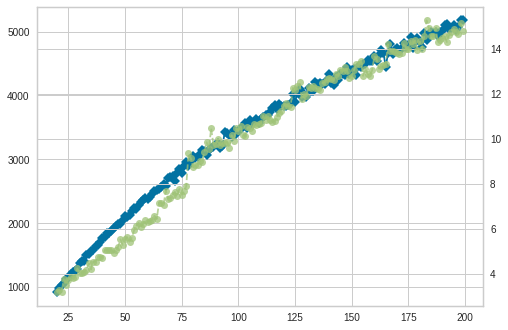

In [ ]:
k_model = KMeans()
visualizer = KElbowVisualizer(k_model, k=(20,200), metric='distortion') #metric: 'distortion', 'silhouette', 'calinski_harabaz_score'
visualizer.fit(np.array(predictions))

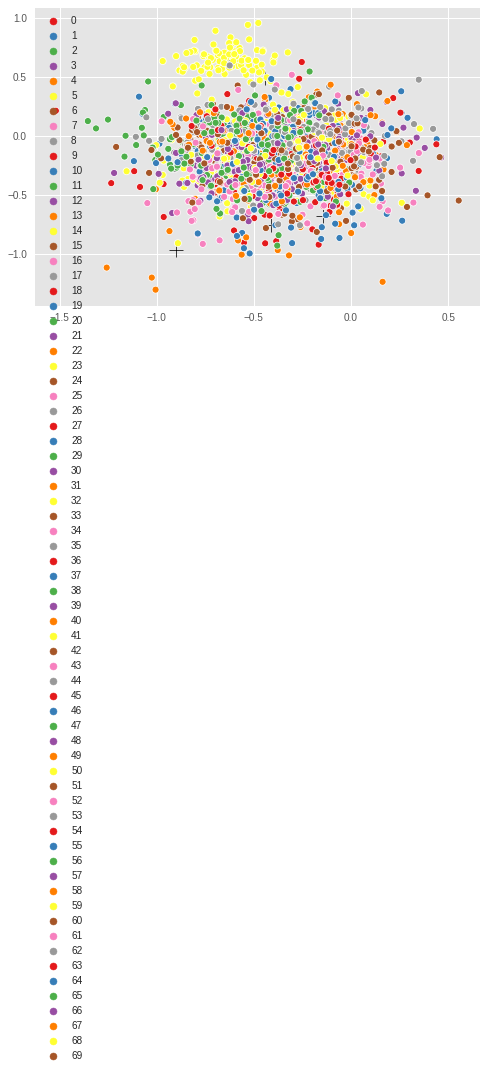

In [ ]:
#looks like the ideal number is 60 clusters
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sea
style.use('ggplot')

X = np.array(predictions)

#plt.scatter(X[:, 0],X[:, 1], s=150, linewidths = 1, zorder = 10)
#plt.show()

n_clusters = 70
clf = KMeans(n_clusters=n_clusters)
clf.fit(X)
centroids = clf.cluster_centers_
labels = clf.labels_

sea.scatterplot(clf.cluster_centers_[:,0], clf.cluster_centers_[:,1], 
                marker='+', 
                color='black', 
                s=200)
sea.scatterplot(X[:,0], X[:,1], hue=labels, 
                palette=sea.color_palette("Set1", n_colors=n_clusters))

#for i in range(len(X)):
#    plt.plot(X[i][0], X[i][1], 'b.', markersize = 10)
#plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)
#plt.show()

In [ ]:
#associate each article with a label
list_of_dicts = []
for a, p, l, n in zip(articles, predictions, labels, names):
  the_dict = {'article':a, 'company':n, 'cluster':str(l)}
  list_of_dicts.append(the_dict)
with open('k_means_clusters.json', 'w', encoding='utf-8') as out_file:
  json.dump({'data':list_of_dicts}, out_file, indent=2, ensure_ascii=False)

In [ ]:
#find the article with the shortest distance from each centroid
distances = clf.transform(X).tolist()
min_ds = []
for i, c in enumerate(centroids): #n = 60
  #print("Looking at the {}th centroid.".format(i))
  ds = []
  for a, p, l, d in zip(articles, predictions, labels, distances): #n = 1154 each
    if i == l:
      ds.append(d)
  min_d = np.argmin(ds)
  #print(min_d)
  min_ds.append(min_d)
print("There are {} centroid-distance pairs.".format(len(min_ds)))

#print the articles and arrange in a json
my_data = []
count = 0
for j, a in enumerate(articles):
  for c, m in zip(centroids, min_ds):
    if j == m:
      #print(str(m) + " : " + a)
      #print('')
      my_dict = {
          'cluster':count,
          'article':j,
          'company':names[j],
          'project tag':'',
          'text':a
      }
      my_data.append(my_dict)
      count += 1
with open('BERT_cluster_results.json', 'w', encoding='utf-8') as out_file:
  json.dump({'data':my_data}, out_file, indent=2, ensure_ascii=False)

There are 70 centroid-distance pairs.
